In [255]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.metrics import accuracy_score , balanced_accuracy_score, f1_score, roc_auc_score
import time

In [256]:
df = pd.read_csv('data/dataFile.csv')
df

,seconds_elapsed,z_accelerometer,y_accelerometer,x_accelerometer,z_gyroscope,y_gyroscope,x_gyroscope,user
0,0.029490,0.620725,-0.024275,0.340136,0.015129,-0.497939,-0.129197,2
1,0.040027,-0.743177,-0.262221,-0.391995,0.203035,0.026631,-0.031968,3
2,0.040460,0.600845,0.465898,-1.121842,-0.556805,-0.030059,-0.312905,1
3,0.041894,1.271829,-0.032704,-0.037981,-0.022566,-0.200779,-0.155414,2
4,0.049252,1.260347,-0.319836,-0.342097,-0.110204,0.161805,-0.306240,1
...,...,...,...,...,...,...,...,...
286806,2906.188554,NaN,NaN,NaN,NaN,NaN,NaN,1
286807,2906.198618,NaN,NaN,NaN,NaN,NaN,NaN,1
286808,2906.208682,NaN,NaN,NaN,NaN,NaN,NaN,1
286809,2906.218746,NaN,NaN,NaN,NaN,NaN,NaN,1


In [257]:
df.user.value_counts()

2    117134
1     88248
3     81429
Name: user, dtype: int64

#### Defining the target and the features the model will use 

In [258]:
target = 'user'
features = df.columns.to_list()
remove = ['user']
features = [x for x in features if x not in remove ]
features

['seconds_elapsed',
 'z_accelerometer',
 'y_accelerometer',
 'x_accelerometer',
 'z_gyroscope',
 'y_gyroscope',
 'x_gyroscope']

In [259]:
# Convert time from datetime to unix, so the model can use it
df['seconds_elapsed'] = pd.to_datetime(df['seconds_elapsed']).astype('int64') // 10**9

X = df[features]
y= df[target]


# Split the data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
X, y, random_state=42, stratify=y, test_size=0.3)

#### Now, we build our pipeline

In [260]:
# Separate categorical and numerical columns
from sklearn.impute import SimpleImputer


categorical_cols = X.select_dtypes(exclude=['number']).columns.to_list()
numerical_cols = X.select_dtypes(include=['number']).columns.to_list()


# Pipeline for the categorical data
categorical_pipeline = Pipeline(steps=[
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')) 
])

# Pipeline for the numeric data
numeric_pipeline = Pipeline(steps=[
    ('imp', SimpleImputer(strategy="mean")),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('categorical', categorical_pipeline, categorical_cols),
    ('numerical', numeric_pipeline ,numerical_cols)
    ], remainder='passthrough')



In [261]:
# Assemble the preprocessor and the model together using a Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
    ])



# Fit the model
pipeline.fit(X_train, y_train)


# Predict using the best model
y_pred = pipeline.predict(X_test)
y_probs = pipeline.predict_proba(X_test)

In [262]:
# Get the performance scores
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
bcc = balanced_accuracy_score(y_true=y_test, y_pred=y_pred)
auc = roc_auc_score(y_true=y_test, y_score=y_probs, average='macro', multi_class='ovo')

print("Accuracy: ", acc)
print("Balanced Accuracy Score: ", bcc)
print("AUC Score: ", auc)

Accuracy:  0.8087025242898982
Balanced Accuracy Score:  0.8009313188765116
AUC Score:  0.9371769290774541


### Get the importance of each feature

In [263]:
# Get the trained Random Forest model
rf_model = pipeline.named_steps['model']

# Get feature names after preprocessing
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Get importances
importances = rf_model.feature_importances_

# Pair names and importances
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Print top features
for name, score in feature_importance[:10]:
    print(f"{name}: {score:.4f}")


numerical__z_gyroscope: 0.2578
numerical__x_accelerometer: 0.1695
numerical__y_accelerometer: 0.1497
numerical__x_gyroscope: 0.1494
numerical__y_gyroscope: 0.1385
numerical__z_accelerometer: 0.1352
numerical__seconds_elapsed: 0.0000


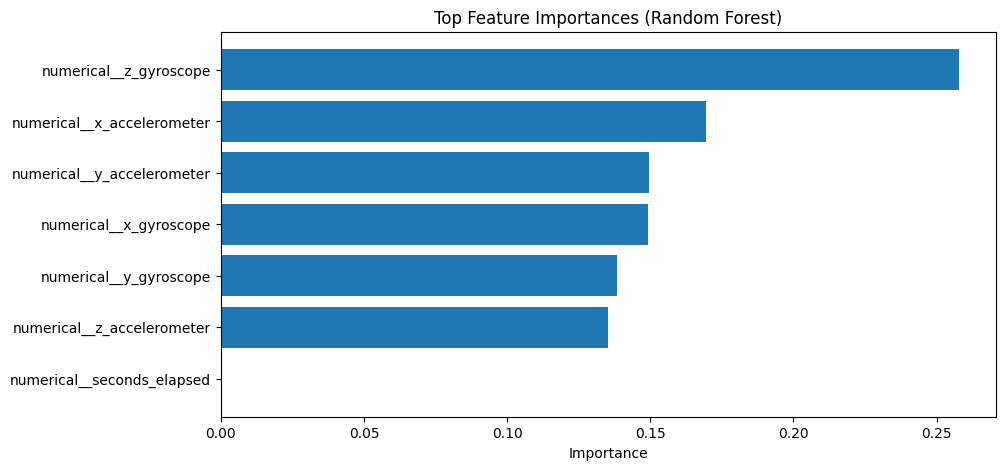

In [264]:
import matplotlib.pyplot as plt

# Show the top 10 features
top_n = 10 
names, scores = zip(*feature_importance[:top_n])

plt.figure(figsize=(10, 5))
# Reverse for descending order
plt.barh(names[::-1], scores[::-1])  
plt.xlabel("Importance")
plt.title("Top Feature Importances (Random Forest)")
plt.show()


/var/folders/j6/hnb1wkw115x3893s7581k7s40000gn/T/ipykernel_69993/1861393590.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df.user, palette="pastel")


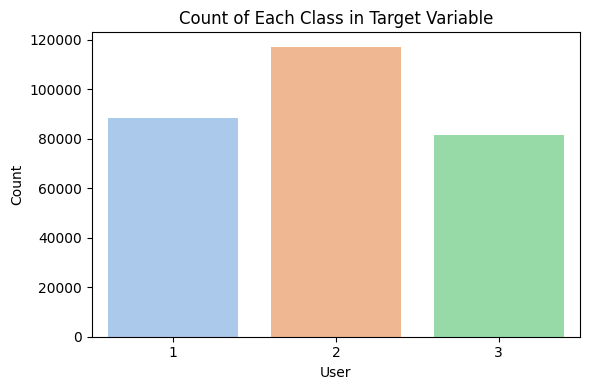

In [265]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming y is your target variable as a Pandas Series or array
# Convert to Series if needed


# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df.user, palette="pastel")

plt.title("Count of Each Class in Target Variable")
plt.xlabel("User")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
